cpu will be used for training the PaiNN model
Current loss 33.30836868286133 Current batch 0/1047 (0.00%)


KeyboardInterrupt: 

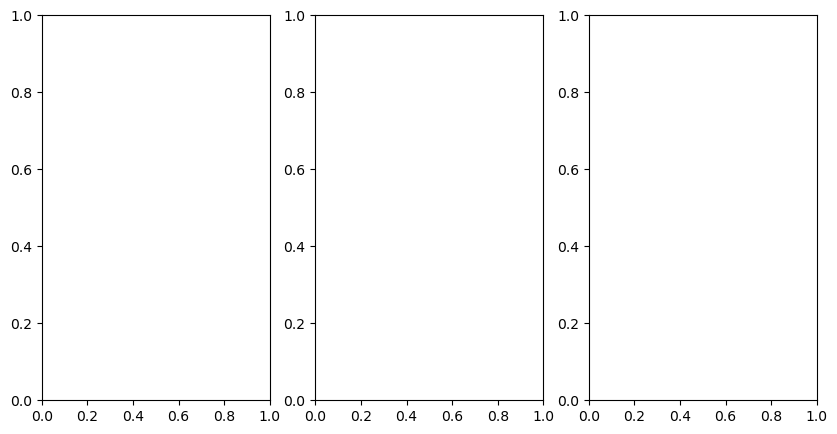

In [1]:
import os
import torch
import torch.nn as nn
import numpy
from Dataloader import DataLoaderQM9
from Model import PaiNN
from Training import Trainer
from Model import saveModel, mse, mae, test
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Model = PaiNN(r_cut=5,
                device=device
                ).to(device)
def training():
        global Model
        print(f"{device} will be used for training the PaiNN model")

        if torch.cuda.device_count() > 1:
              print(f"Using {torch.cuda.device_count()} GPUS.")
              Model = nn.DataParallel(Model)
        train_set = DataLoaderQM9(r_cut=5,batch_size=100)
        optimizer = torch.optim.Adam(params=Model.parameters(), lr = 5e-4, weight_decay = 0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience = 5)
        trainer = Trainer(
            Model=Model,
            loss=mse,
            target=2,
            optimizer=optimizer,
            Dataloader=train_set,
            scheduler=scheduler,
            device=device
        )
        trainer._train(num_epoch = 100, early_stopping = 30)
        trainer.plot_data()

if __name__=="__main__":
    training()

    # To save the best model
    saveModel(Model, path="./final_best_PaiNNModel.pth")

    # To load the best model
    best_model = PaiNN(r_cut=5, device=device).to(device)
    best_model.load_state_dict(torch.load("./final_best_PaiNNModel.pth"))

    # To test the best model
    test(best_model, DataLoaderQM9(r_cut=5, batch_size=100).get_test())
